In [ ]:
# import necessary libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

# Imbalanced handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
# import the data
df = pd.read_csv(r"C:\Users\dhanu\OneDrive\Documents\books academic\p-1\datasets\creditcard1.csv~\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
# check for null values, if present, remove them
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
# No null values, free to train the data

# separate features and target variables
X = df.drop(columns = ["Class"])
Y = df["Class"]

# split the data into training and testing sets, including stratification to maintain class distribution
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [31]:
# smote to oversample minority class samples
smote = SMOTE(sampling_strategy = 0.1, random_state = 42)

# training functions to fit the data into the model after oversampling
def train_model(model, x_train, y_train):
    pipe = ImbPipeline([("smote", smote), ("clf", model)])
    pipe.fit(x_train, y_train)
    return pipe


def precision_at_k(y_true, y_proba, k=0.05):
    """
    Definition : Amongst the fraud detected by the model, how many are actually frauds?
    Precision among the top k% of samples ranked by predicted probability.
    """
    n = len(y_proba)
    cutoff = max(1, int(n * k))  # number of samples in top k%
    idx = np.argsort(y_proba)[::-1][:cutoff]  # indices of top k% scores
    return y_true.iloc[idx].sum() / cutoff


def recall_at_k(y_true, y_proba, k=0.05):
    """
    Definition : Amongst all the frauds, how many are detected by the model?
    Recall among the top k% of samples ranked by predicted probability.
    """
    n = len(y_proba)
    cutoff = max(1, int(n * k))
    idx = np.argsort(y_proba)[::-1][:cutoff]
    frauds_captured = y_true.iloc[idx].sum()
    total_frauds = y_true.sum()
    return frauds_captured / max(1, total_frauds)



In [32]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5, k_list=(0.01, 0.05, 0.10)):
    """
    Evaluate trained model with threshold + top-k metrics ( at 1%, 5%, 10%)
    Vary the threshold to see how precision and recall changes
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int) # store the predictions based on the threshold

    print(f"\n====> {name} (Threshold={threshold}) <====")
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred, digits=4))

    # ROC, PR curves
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC - {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"PR - {name}")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    total = np.sum(cm)

    names = ['True Neg','False Pos','False Neg','True Pos']          # names that are displayed in confusion matrix
    counts = [f"{value}" for value in cm.flatten()]                  # number of samples in each category
    percentages = [f"{(value/total):.2%}" for value in cm.flatten()] # calculate and assign the percentages for each category
    labels = [f"{n}\n{c}\n{p}" for n,c,p in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(cm.shape)                    # keep it as an array with the shape of confusion matrix

    plt.figure(figsize = (6,5))
    sns.heatmap(cm, annot = labels, fmt = '', cmap = "Blues", cbar = False, linewidths = 1, linecolor = 'gray')
    plt.xlabel('Predicted')
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Top-k metrics
    for k in k_list:
        p_at_k = precision_at_k(y_test, y_proba, k)
        r_at_k = recall_at_k(y_test, y_proba, k)
        print(f"Precision@{int(k*100)}%: {p_at_k:.4f}")
        print(f"Recall@{int(k*100)}%: {r_at_k:.4f}", "\n")

    return {"model": name, "threshold": threshold, "roc_auc": roc_auc_score(y_test, y_proba)}


In [33]:
# store the models in a dictionary for easy access and training
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42), # use 'balanced' to give more weight to minority class
    
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=8, class_weight="balanced",
        random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", use_label_encoder=False,
        random_state=42, n_jobs=-1
    )
}



====> Logistic Regression (Threshold=0.3) <====
ROC AUC: 0.9757080624877976
              precision    recall  f1-score   support

           0     0.9999    0.9785    0.9891     56864
           1     0.0687    0.9184    0.1278        98

    accuracy                         0.9784     56962
   macro avg     0.5343    0.9485    0.5585     56962
weighted avg     0.9983    0.9784    0.9876     56962



c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


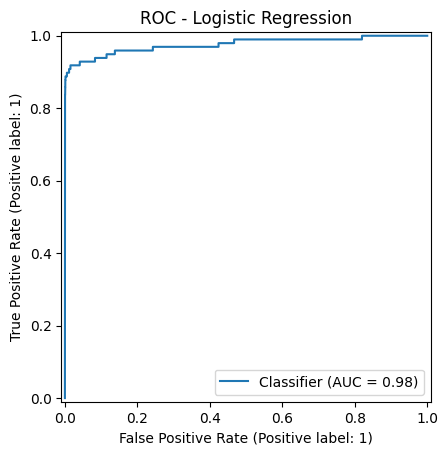

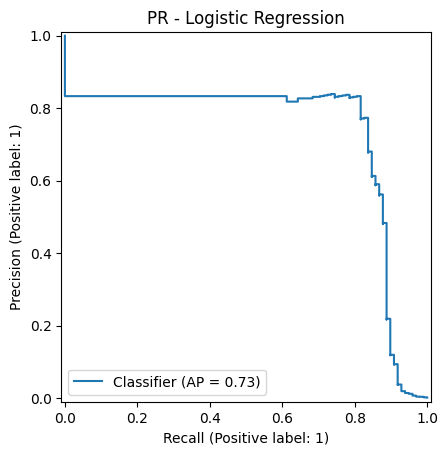

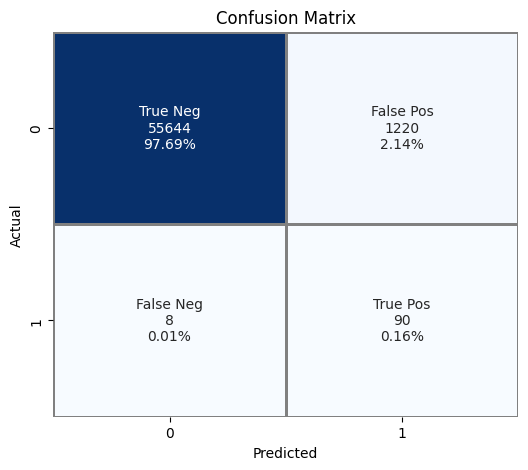

Precision@1%: 0.1547
Recall@1%: 0.8980 

Precision@5%: 0.0320
Recall@5%: 0.9286 

Precision@10%: 0.0162
Recall@10%: 0.9388 


====> Logistic Regression (Threshold=0.5) <====
ROC AUC: 0.9757080624877976
              precision    recall  f1-score   support

           0     0.9998    0.9897    0.9947     56864
           1     0.1306    0.8980    0.2280        98

    accuracy                         0.9895     56962
   macro avg     0.5652    0.9438    0.6114     56962
weighted avg     0.9983    0.9895    0.9934     56962



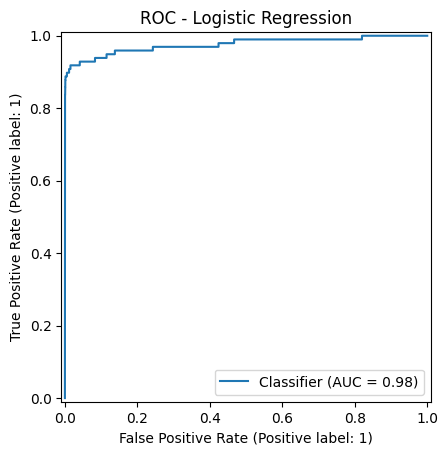

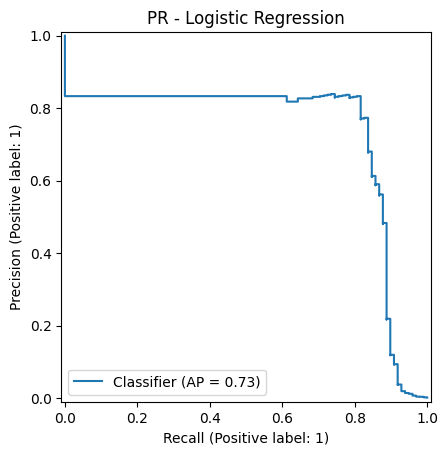

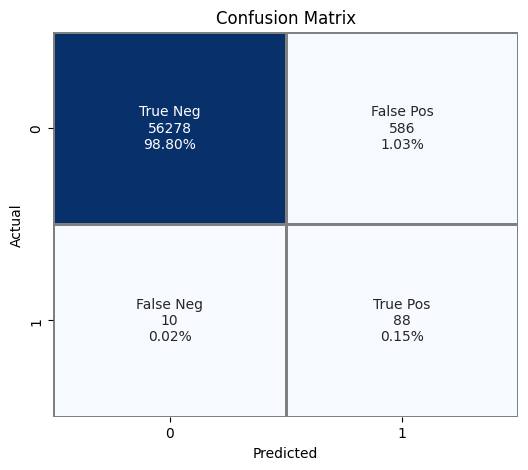

Precision@1%: 0.1547
Recall@1%: 0.8980 

Precision@5%: 0.0320
Recall@5%: 0.9286 

Precision@10%: 0.0162
Recall@10%: 0.9388 



In [34]:
results = []
thresholds = [0.3, 0.5]

name = "Logistic Regression"
trained_model = train_model(models[name], x_train, y_train)
for t in thresholds:
    res = evaluate_model(name, trained_model, x_test, y_test, threshold=t)
    results.append(res)


====> Random Forest (Threshold=0.3) <====
ROC AUC: 0.9828401886922467
              precision    recall  f1-score   support

           0     0.9998    0.9915    0.9957     56864
           1     0.1547    0.8980    0.2639        98

    accuracy                         0.9914     56962
   macro avg     0.5772    0.9448    0.6298     56962
weighted avg     0.9984    0.9914    0.9944     56962



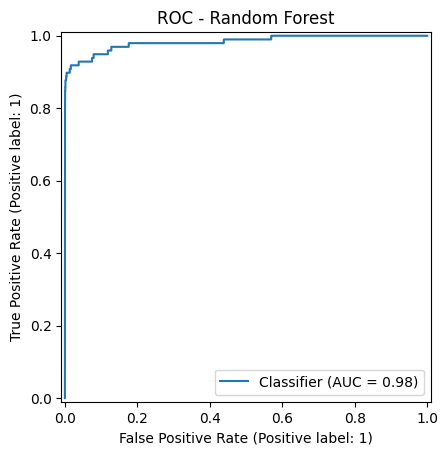

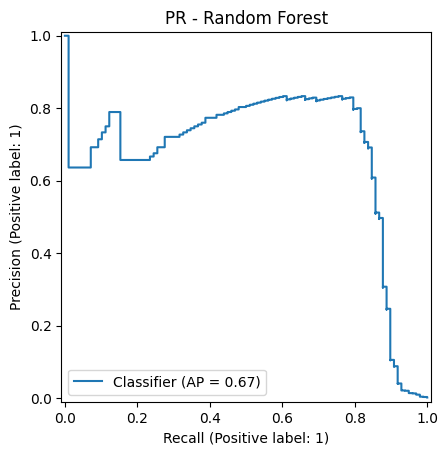

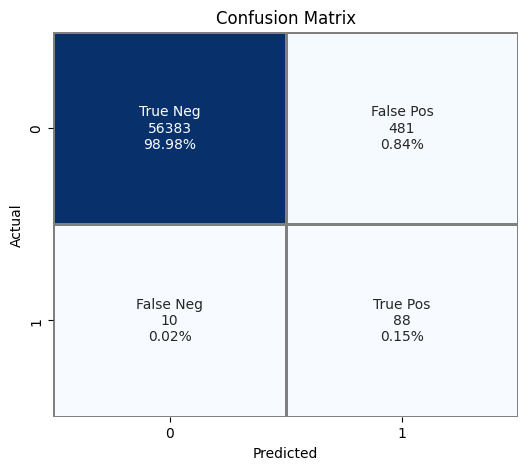

Precision@1%: 0.1547
Recall@1%: 0.8980 

Precision@5%: 0.0320
Recall@5%: 0.9286 

Precision@10%: 0.0163
Recall@10%: 0.9490 


====> Random Forest (Threshold=0.5) <====
ROC AUC: 0.9828401886922467
              precision    recall  f1-score   support

           0     0.9998    0.9974    0.9986     56864
           1     0.3691    0.8776    0.5196        98

    accuracy                         0.9972     56962
   macro avg     0.6844    0.9375    0.7591     56962
weighted avg     0.9987    0.9972    0.9978     56962



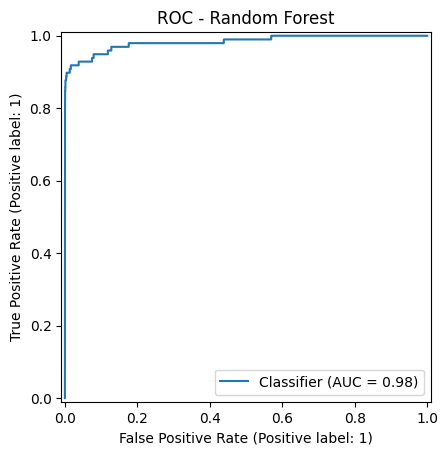

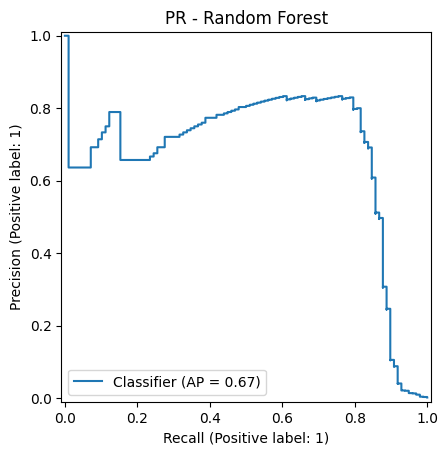

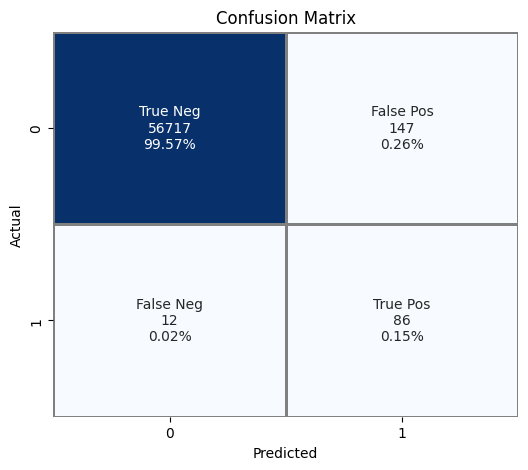

Precision@1%: 0.1547
Recall@1%: 0.8980 

Precision@5%: 0.0320
Recall@5%: 0.9286 

Precision@10%: 0.0163
Recall@10%: 0.9490 



In [35]:
name = "Random Forest"
trained_model = train_model(models[name], x_train, y_train)
for t in thresholds:
    res = evaluate_model(name, trained_model, x_test, y_test, threshold=t)
    results.append(res)


c:\Users\dhanu\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:42:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



====> XGBoost (Threshold=0.3) <====
ROC AUC: 0.9821243740884087
              precision    recall  f1-score   support

           0     0.9998    0.9990    0.9994     56864
           1     0.6028    0.8673    0.7113        98

    accuracy                         0.9988     56962
   macro avg     0.8013    0.9332    0.8553     56962
weighted avg     0.9991    0.9988    0.9989     56962



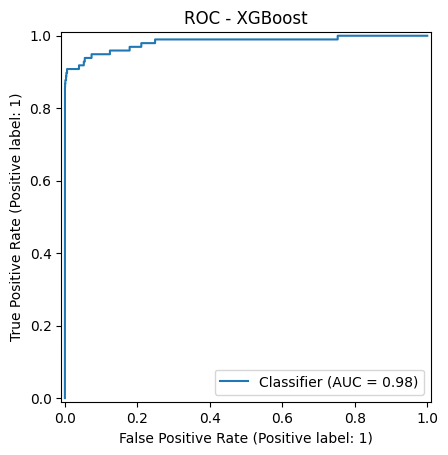

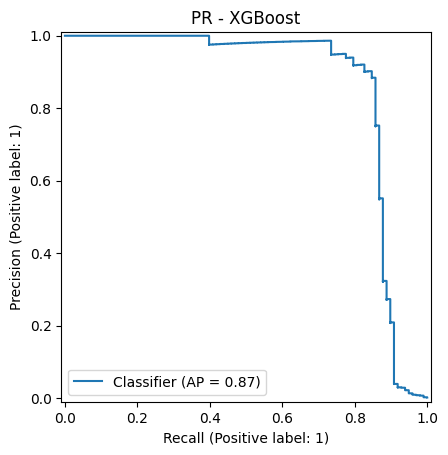

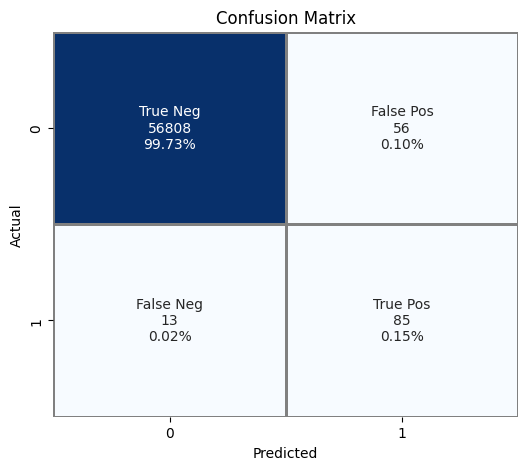

Precision@1%: 0.1564
Recall@1%: 0.9082 

Precision@5%: 0.0316
Recall@5%: 0.9184 

Precision@10%: 0.0163
Recall@10%: 0.9490 


====> XGBoost (Threshold=0.5) <====
ROC AUC: 0.9821243740884087
              precision    recall  f1-score   support

           0     0.9998    0.9995    0.9996     56864
           1     0.7522    0.8673    0.8057        98

    accuracy                         0.9993     56962
   macro avg     0.8760    0.9334    0.9027     56962
weighted avg     0.9993    0.9993    0.9993     56962



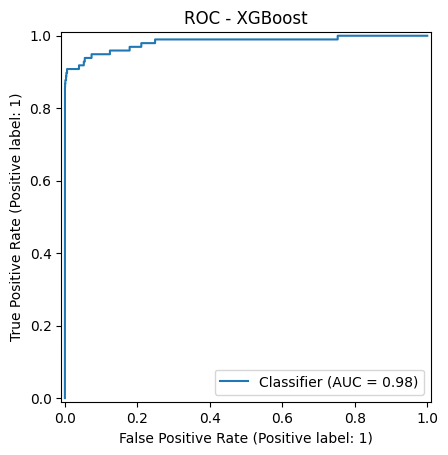

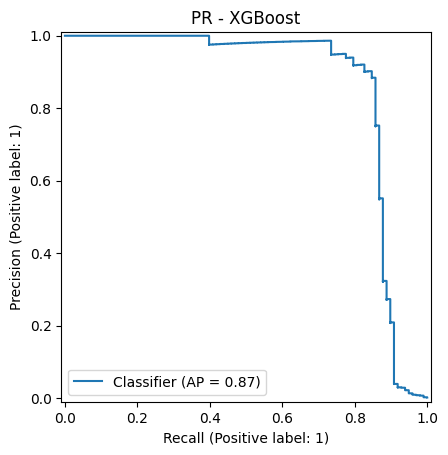

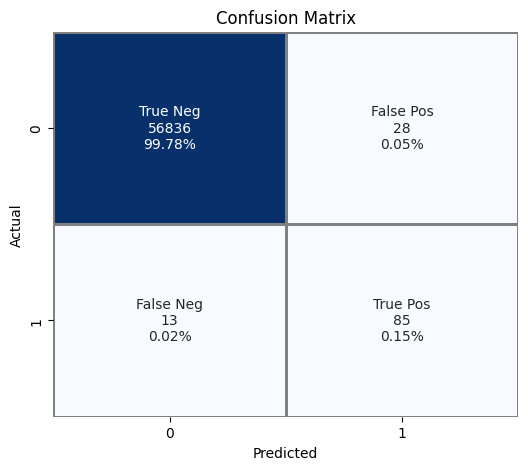

Precision@1%: 0.1564
Recall@1%: 0.9082 

Precision@5%: 0.0316
Recall@5%: 0.9184 

Precision@10%: 0.0163
Recall@10%: 0.9490 



In [36]:
name = "XGBoost"
trained_model = train_model(models[name], x_train, y_train)
for t in thresholds:
    res = evaluate_model(name, trained_model, x_test, y_test, threshold=t)
    results.append(res)


In [37]:
only_fraud = y_test[y_test == 1].shape[0]
only_normal = y_test[y_test == 0].shape[0]

print(f"Total fraud samples in test set: {only_fraud}")
print(f"Total normal samples in test set: {only_normal}")


Total fraud samples in test set: 98
Total normal samples in test set: 56864


### Summary of performance of all models : 

(at threshold = 0.3)

| Model                | ROC_AUC | PR_AP | Precision | Recall | Precision @1% | Recall @1% | Precision @5% | Recall @5% | Precision @10% | Recall @10% |
|----------------------|---------|-------|:---------:|:------:|:--------------:|:-----------:|:--------------:|:-----------:|:---------------:|:------------:|
| Logistic Regression  | 0.9757  | 0.73  |  6.8%  | 91.8% | 0.1547       | 0.8980     | 0.0320       | 0.9286     | 0.0162        | 0.9388      |
| Random Forest        | 0.9828  | 0.67  | 15.4%  | 89.8% | 0.1547       | 0.8980     | 0.0320       | 0.9286     | 0.0163        | 0.9490      |
| XGBoosting           | 0.9821  | 0.87  | 60.3%  | 86.7% | 0.1564       | 0.9082     | 0.0316       | 0.9184     | 0.0163        | 0.9490      |


(at theshold = 0.5)

| Model                | ROC_AUC | PR_AP | Precision | Recall | Precision @1% | Recall @1% | Precision @5% | Recall @5% | Precision @10% | Recall @10% |
|----------------------|---------|-------|:---------:|:------:|:--------------:|:-----------:|:--------------:|:-----------:|:---------------:|:------------:|
| Logistic Regression  | 0.9757  | 0.73  | 13.6%  | 89.8% | 0.1547       | 0.8980     | 0.0320       | 0.9286     | 0.0162        | 0.9388      |
| Random Forest        | 0.9828  | 0.67  | 36.9%  | 87.7% | 0.1547       | 0.8980     | 0.0320       | 0.9286     | 0.0163        | 0.9490      |
| XGBoosting           | 0.9821  | 0.87  | 75.2%  | 86.7% | 0.1564       | 0.9082     | 0.0316       | 0.9184     | 0.0163        | 0.9490      |

Best classifier identified to be XGBoosting. Precision and Recall percentages are higher than RandomForest and LogisticRegression. 